In [6]:
##DESCRIPTION
# This notebook calculates the so called "Polygons" to describe how a system under test reacts to a set of performance tests.


In [7]:
install.packages("RColorBrewer", repos='http://cran.us.r-project.org')
install.packages("gridExtra")
install.packages("getPass")
install.packages("RPostgreSQL")

library("RColorBrewer")
library(ggplot2)
library(gridExtra)
library(getPass)
library(RPostgreSQL)
library(dplyr)
library(stringr)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: DBI


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [8]:
db_connection <- DBI::dbConnect(dbDriver(drvName = "PostgreSQL"), dbname = Sys.getenv("DB_NAME"), host=Sys.getenv("HOST_NAME"), port="5432", user=Sys.getenv("POSTGRES_USERNAME"), password=Sys.getenv("POSTGRES_PASSWORD"))
dbGetQuery(db_connection, "SELECT id::text, name FROM projects") 

,id,name
,<chr>,<chr>
1,97abf9ab-e8d9-4db5-ad5a-66e310f02ce4,Sockshop


In [9]:
# Define the name of the project to analyze
project_name <- "Sockshop"

project_id = dbGetQuery(db_connection, str_glue("SELECT id::text FROM projects WHERE name='{project}'", project = project_name))$id

project_id

[1] "97abf9ab-e8d9-4db5-ad5a-66e310f02ce4"

In [20]:
sql_operational_profile = "
    SELECT users, frequency FROM operational_profile_observations 
        WHERE operational_profile = (SELECT id FROM operational_profiles WHERE project = ?project)"
operational_profile <- dbGetQuery(db_connection, sqlInterpolate(db_connection, sql_operational_profile, project = project_id))
operational_profile[,1] <- operational_profile[,1]
operational_profile

,users,frequency
,<int>,<int>
1,0,3
2,1,11
3,2,6
4,3,6
5,4,6
6,5,8
7,10,2
8,11,4
9,12,2


In [21]:
sql_all_data = "
    SELECT tests.id::text AS test_id, test_sets.id::text AS test_set_id, test_properties.value::numeric AS users, metrics.abbreviation AS metric, items.name AS item_name, results.value AS item_value
        FROM results 
        INNER JOIN tests ON results.test = tests.id
        INNER JOIN items ON results.item = items.id
        INNER JOIN test_properties ON (test_properties.test = tests.id AND test_properties.name = 'load')
        INNER JOIN metrics ON results.metric = metrics.id 
        INNER JOIN test_set_tests ON (test_set_tests.test = tests.id)
        INNER JOIN test_sets ON (test_sets.id = test_set_tests.test_set AND test_sets.project = tests.project)
        WHERE tests.project = ?project AND metrics.abbreviation IN ('art', 'sdrt', 'mix')"

all_data = dbGetQuery(db_connection, sqlInterpolate(db_connection, sql_all_data, project = project_id))

list_of_microservices = as.data.frame(unique(all_data[,5]))
no_of_microservices = nrow(list_of_microservices)

test_users_metric<-unique(all_data[,c(1:4)])
#test_users_metric

In [22]:
test_users_metric[list_of_microservices[,1]]<-NA
#test_users_metric

In [23]:
#If the tests occur too fast, it might be that some services have no data. This case is not handled, yet.

for (i in 1:nrow(test_users_metric)) {
    search_test_id <- test_users_metric[i,1]
    search_metric <- test_users_metric[i,4]
    
    for (j in 1:no_of_microservices) {
        search_microservice <- list_of_microservices[j,]
        
        row <- filter(all_data, test_id == search_test_id & metric == search_metric & item_name == search_microservice)
        
        if (dim(row)[1] > 0) {
            found_value = row$item_value
            
            if  (!is.na(found_value)) {
                test_users_metric[i,j+4] <- found_value
            } else {
                test_users_metric[i,j+4] <- 99999999.00 
                print("NA=toobig")
            }
        } else {
            test_users_metric[i,j+4] <- 99999999.00
        }
    }
}
raw_data <- test_users_metric
raw_data


,test_id,test_set_id,users,metric,get_cart,get_catalogue1,get_catalogue2,get_catalogue3,get_category,get_customer,⋯,get_index,get_item,get_orders,get_related,get_tags,login,add_item_to_cart,get_address,get_basket,get_card
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,82271f88-6131-4491-b0b2-471940fe6238,db07c2f5-8def-4399-bb16-642664776c42,2,art,20.5484363,32.8272127,37.19828171,10.32817100,4.78504671,23.67656786,⋯,8.6108639,24.70792150,35.06514671,20.11757143,18.67904986,60.76279314,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08
2,82271f88-6131-4491-b0b2-471940fe6238,db07c2f5-8def-4399-bb16-642664776c42,2,sdrt,30.3703704,31.1111111,33.33333333,7.40740741,3.70370370,28.88888889,⋯,0.7407407,31.11111111,30.37037037,34.07407407,30.37037037,42.22222222,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08
3,82271f88-6131-4491-b0b2-471940fe6238,db07c2f5-8def-4399-bb16-642664776c42,2,mix,0.2427184,0.1407767,0.03398058,0.03398058,0.03398058,0.10194175,⋯,0.1407767,0.06796117,0.03398058,0.03398058,0.03398058,0.03398058,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08
43,a792571b-60d4-4041-9789-cb5c9c928e71,14d4cb89-bd23-4720-a445-c81c607d1871,50,art,24.9376143,27.2444696,27.85388188,23.57004669,23.19702496,23.79319637,⋯,27.0551944,22.62020640,20.63640270,24.62984328,26.01651348,28.00690409,2.231828e+01,1.984748e+01,2.250306e+01,1.974317e+01
44,a792571b-60d4-4041-9789-cb5c9c928e71,14d4cb89-bd23-4720-a445-c81c607d1871,50,sdrt,15.5555556,16.2962963,17.77777778,16.29629630,16.29629630,14.81481481,⋯,18.5185185,14.81481481,13.33333333,15.55555556,16.29629630,14.81481481,1.481481e+01,1.333333e+01,1.555556e+01,1.555556e+01
45,a792571b-60d4-4041-9789-cb5c9c928e71,14d4cb89-bd23-4720-a445-c81c607d1871,50,mix,0.2295392,0.1186619,0.03197980,0.03197980,0.03197980,0.11066695,⋯,0.1087734,0.08857564,0.03660846,0.04186829,0.03197980,0.02756154,1.051967e-02,9.888491e-03,1.009888e-02,9.888491e-03
97,3b0944dd-879e-4ab9-a070-990865b1c101,14d4cb89-bd23-4720-a445-c81c607d1871,100,art,29.3437880,389.1138879,175.25512263,4.44623922,13.16444428,5.07664920,⋯,27.2266154,4.77704370,8.93182952,72.09105262,4.49619351,91.87333777,5.109417e+00,1.582203e+01,5.111159e+00,4.800980e+00
98,3b0944dd-879e-4ab9-a070-990865b1c101,14d4cb89-bd23-4720-a445-c81c607d1871,100,sdrt,4.4444444,5.9259259,2.96296296,2.22222222,4.44444444,2.96296296,⋯,8.1481481,2.96296296,3.70370370,2.96296296,2.96296296,168.14814815,2.962963e+00,2.222222e+00,2.222222e+00,2.962963e+00
99,3b0944dd-879e-4ab9-a070-990865b1c101,14d4cb89-bd23-4720-a445-c81c607d1871,100,mix,0.2253846,0.1265385,0.02923077,0.02769231,0.03000000,0.09884615,⋯,0.1473077,0.07961538,0.03384615,0.03730769,0.02769231,0.03615385,9.615385e-03,9.615385e-03,9.615385e-03,9.615385e-03


In [25]:
tests <- unique(raw_data[,1:3]) 
#max number for which test was made
max_no_of_users <- max(raw_data[,3])
print ("max_no") 
print(max_no_of_users)
min_no_of_users <- min(raw_data[,3])
print(min_no_of_users)
user_load <- operational_profile[,1]
print("user_load",user_load)
print("access count")
access_count <- operational_profile[,2]
print(access_count)
max_no_of_requests <- max(user_load)
scale_factor <- max_no_of_users/max_no_of_requests
print("max_no_request")
print(max_no_of_requests)
print(scale_factor)
scaled_user_load <- floor(scale_factor * user_load)
print(scaled_user_load)

[1] "max_no"
[1] 300
[1] 2
[1] "user_load"
[1] "access count"
 [1]  3 11  6  6  6  8  2  4  2  2  4  4  8  7  7  7  7  6  5  1  4  3  3  4 10
[26] 13 21 10 20 12 19 25 28 26 18 16  1 17 15  6  1
[1] "max_no_request"
[1] 105
[1] 2.857143
 [1]   0   2   5   8  11  14  28  31  34  37  42  45  48  51  54  57  60  62  65
[20]  68  71  74  77  80  85 100 114 120 128 142 157 171 185 200 214 228 300 242
[39] 257 271 285


In [47]:
##Create aggregate values (by fifty) of the user frequency from "operational_profile" 
##you are not supposed to understand this
steps <- 50

calculate_aggregated_values <- function() {    
    access_frequency <- access_count/sum(access_count)
    #by_fifty <- which((scaled_user_load %% steps) == 0)
    #hack need to rewrite to be general
    by_fifty <- c(1,14,26,31,34,38,41)
    print(by_fifty)
    no_of_aggregated_rows = length(by_fifty)
    print (no_of_aggregated_rows)
    binProb <- c()
    for (i in 1:no_of_aggregated_rows) {
        if (i==1) {
            binProb[i] <- sum(access_frequency[1:by_fifty[i]])
        } else {
            binProb[i] <- sum(access_frequency[(by_fifty[i-1]+1):by_fifty[i]])
        }
          print(binProb[i])
    }
  

    matrix(c(scaled_user_load[by_fifty], binProb), ncol=2, nrow=no_of_aggregated_rows, dimnames=list(c(1:no_of_aggregated_rows), c("Workload (number of users)", "Domain metric per workload")))
}

aggregated_values_from_operational_profile <- calculate_aggregated_values()
#aggregated_values_from_operational_profile
#fix to match test data
#hack need to rewrite to be general
aggregated_values_from_operational_profile[,1] <- c(0,50,100,150,200,250,300)
aggregated_values_from_operational_profile

[1]  1 14 26 31 34 38 41
[1] 7
[1] 0.007936508
[1] 0.1851852
[1] 0.1851852
[1] 0.2169312
[1] 0.2089947
[1] 0.1375661
[1] 0.05820106


,Workload (number of users),Domain metric per workload
1,0,0.007936508
2,50,0.185185185
3,100,0.185185185
4,150,0.216931217
5,200,0.208994709
6,250,0.137566138
7,300,0.058201058


In [48]:
#Define the threshold for each service. The threshold is a vector computed as avg+3*SD for the configuration with 
#Users=2, Memory=4, CPU=1, CartReplica=1   

data_of_min_user<-raw_data[raw_data$users==min_no_of_users,]
test_of_min_user<-tests[tests$users==min_no_of_users,]

avg <-data_of_min_user[data_of_min_user$metric=="art",][,-c(1:4)]
sd <- data_of_min_user[data_of_min_user$metric=="sdrt",][,-c(1:4)]
threshold<-data.frame(test_of_min_user,avg+3*sd)

#Check the first line of the dataframe thereshold: it must be one line
head(threshold)
data_of_min_user

,test_id,test_set_id,users,get_cart,get_catalogue1,get_catalogue2,get_catalogue3,get_category,get_customer,get_customer_orders,⋯,get_index,get_item,get_orders,get_related,get_tags,login,add_item_to_cart,get_address,get_basket,get_card
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,82271f88-6131-4491-b0b2-471940fe6238,db07c2f5-8def-4399-bb16-642664776c42,2,111.6595,126.1605,137.1983,32.55039,15.89616,110.3432,6.208144,⋯,10.83309,118.0413,126.1763,122.3398,109.7902,187.4295,4e+08,4e+08,4e+08,4e+08


,test_id,test_set_id,users,metric,get_cart,get_catalogue1,get_catalogue2,get_catalogue3,get_category,get_customer,⋯,get_index,get_item,get_orders,get_related,get_tags,login,add_item_to_cart,get_address,get_basket,get_card
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,82271f88-6131-4491-b0b2-471940fe6238,db07c2f5-8def-4399-bb16-642664776c42,2,art,20.5484363,32.8272127,37.19828171,10.32817100,4.78504671,23.6765679,⋯,8.6108639,24.70792150,35.06514671,20.11757143,18.67904986,60.76279314,1e+08,1e+08,1e+08,1e+08
2,82271f88-6131-4491-b0b2-471940fe6238,db07c2f5-8def-4399-bb16-642664776c42,2,sdrt,30.3703704,31.1111111,33.33333333,7.40740741,3.70370370,28.8888889,⋯,0.7407407,31.11111111,30.37037037,34.07407407,30.37037037,42.22222222,1e+08,1e+08,1e+08,1e+08
3,82271f88-6131-4491-b0b2-471940fe6238,db07c2f5-8def-4399-bb16-642664776c42,2,mix,0.2427184,0.1407767,0.03398058,0.03398058,0.03398058,0.1019417,⋯,0.1407767,0.06796117,0.03398058,0.03398058,0.03398058,0.03398058,1e+08,1e+08,1e+08,1e+08


In [49]:
#Exclude case with user = 2 from dataFile and check whether each service passes or fail: avg<threshol (Pass). 
#Compute the relative mass for each configuration

tests_without_benchmark<-tests[!tests$users==min_no_of_users,]
raw_data_without_benchmark<-raw_data[!raw_data$users==min_no_of_users,]

avg<-raw_data_without_benchmark[raw_data_without_benchmark$metric=="art",-4]
sd<-raw_data_without_benchmark[raw_data_without_benchmark$metric=="sdrt",-4]
mix<-raw_data_without_benchmark[raw_data_without_benchmark$metric=="mix",-4]



#Check pass/fail for each service. the "mix" value is 0 if fail and mixTemp if pass. Compute the relative mass for each configuration
pass_criteria<-avg



calculate_relative_mass <- function() {    
    relative_mass<-c()

    mix_of_passing_tests<-as.data.frame(matrix(nrow=nrow(tests_without_benchmark), ncol=ncol(raw_data_without_benchmark)-1))

    for(j in 1:nrow(pass_criteria)){
        #print (j)
        mix_of_passing_tests[j,]<-mix[j,]
        for(i in 4:(3+no_of_microservices)){
            #print (i)
            #print (pass_criteria[j,i])
            #print (threshold[i])
            if (!is.na(threshold[i]) & !is.na(pass_criteria[j,i])) {
                if(pass_criteria[j,i]>threshold[i]){
                    #print ("fail")
                    mix_of_passing_tests[j,i]<-0
                } #else print ("pass")
            } #else print ("NA")
        } 
        relative_mass[j]<-sum(mix_of_passing_tests[j,4:(3+no_of_microservices)])
    }
   
    relative_mass
}

relative_mass <- calculate_relative_mass()

#Show first lines of passCriteria
pass_criteria

,test_id,test_set_id,users,get_cart,get_catalogue1,get_catalogue2,get_catalogue3,get_category,get_customer,get_customer_orders,⋯,get_index,get_item,get_orders,get_related,get_tags,login,add_item_to_cart,get_address,get_basket,get_card
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
43,a792571b-60d4-4041-9789-cb5c9c928e71,14d4cb89-bd23-4720-a445-c81c607d1871,50,24.93761,27.24447,27.85388,23.570047,23.19702,23.793196,20.999452,⋯,27.05519,22.620206,20.63640,24.62984,26.016513,28.00690,22.318284,19.847481,22.503063,19.74317
97,3b0944dd-879e-4ab9-a070-990865b1c101,14d4cb89-bd23-4720-a445-c81c607d1871,100,29.34379,389.11389,175.25512,4.446239,13.16444,5.076649,8.591573,⋯,27.22662,4.777044,8.93183,72.09105,4.496194,91.87334,5.109417,15.822026,5.111159,4.80098
151,c01cf8a8-6822-4e26-baa1-24d76d875f27,14d4cb89-bd23-4720-a445-c81c607d1871,150,32.04494,32.79832,34.59512,32.871968,33.59001,31.790789,30.814208,⋯,35.82155,29.786857,30.02550,29.16708,33.773717,39.01463,33.486987,26.750637,23.880510,23.91317
205,c7308604-ec62-4a16-949b-b468711a92a5,14d4cb89-bd23-4720-a445-c81c607d1871,200,24.26830,21.59774,38.29076,27.222928,21.56378,20.213427,21.137960,⋯,24.42411,21.708171,21.24638,24.17593,22.069106,21.51669,17.256494,19.366752,19.934269,18.92281
259,e00a24c8-3b5d-460f-a349-2e190efa7777,14d4cb89-bd23-4720-a445-c81c607d1871,250,46.62845,50.23871,52.49893,49.601594,49.38254,44.913993,39.972943,⋯,54.26306,41.577235,37.76837,43.13131,57.247853,60.79962,44.101340,35.780548,36.796621,34.97205
313,aa23cf28-129f-4c5e-9bc8-3e3d02cee110,14d4cb89-bd23-4720-a445-c81c607d1871,300,131.91041,200.94321,164.83129,100.544170,136.89490,86.642264,114.647081,⋯,197.63060,53.343745,116.83654,50.30971,136.226080,350.20388,47.690322,15.255126,17.885984,13.05485
367,8a690732-4f01-4171-bc01-e1c77b57f673,553f8a94-27e0-4cdd-b0a9-38ad25895cbc,50,26.68654,30.98429,27.54167,25.443111,23.75532,26.220574,22.916899,⋯,32.19024,23.354277,22.89431,23.34421,26.252894,40.48574,26.431393,23.919416,23.430890,21.86132
421,cdb4896f-1587-4b20-abed-0630b55cbbb6,553f8a94-27e0-4cdd-b0a9-38ad25895cbc,150,23.83151,24.28032,23.56987,23.282935,24.45032,23.346072,23.315285,⋯,25.93512,23.764328,22.80370,23.86531,23.731024,25.49815,24.347707,22.317965,22.739981,23.11867
475,df20f720-b267-461e-9404-7776086a178b,553f8a94-27e0-4cdd-b0a9-38ad25895cbc,100,27.85262,27.42971,27.98017,28.133953,28.45603,27.919321,25.474171,⋯,29.18777,26.556128,26.45965,26.14724,28.635665,30.12311,27.400979,24.430750,26.293293,24.58202


In [50]:
#Compute the domain metric for each configuration
tests_without_benchmark$relative_mass<-relative_mass

absolute_mass<-c()

print (tests_without_benchmark)

for(j in 1:nrow(tests_without_benchmark)) {
      print (j)
    absolute_mass[j]<-tests_without_benchmark[j,"relative_mass"]*aggregated_values_from_operational_profile[match(tests_without_benchmark[j,
        "users"], aggregated_values_from_operational_profile[,1]),2]
  
    print (absolute_mass[j])
}
tests_without_benchmark$absolute_mass<-absolute_mass

test_sets<-as.data.frame(unique(all_data[,2]))
colnames(test_sets)[1] <- "test_set_id"

set<-list()
domain_metric_list<-list()
for(i in 1:nrow(test_sets)){
    set[[i]]<-tests_without_benchmark[which(tests_without_benchmark[,2] == test_sets[i,1]),]
    domain_metric_list[[i]]<-set[[i]][,c(3,5)][order(set[[i]][,c(3,5)][,1]),]
}

#Uncomment this to show first lines of domain_metric_list
#head(domain_metric_list)
print("domain metric list")
domain_metric_list

                                  test_id                          test_set_id
43   a792571b-60d4-4041-9789-cb5c9c928e71 14d4cb89-bd23-4720-a445-c81c607d1871
97   3b0944dd-879e-4ab9-a070-990865b1c101 14d4cb89-bd23-4720-a445-c81c607d1871
151  c01cf8a8-6822-4e26-baa1-24d76d875f27 14d4cb89-bd23-4720-a445-c81c607d1871
205  c7308604-ec62-4a16-949b-b468711a92a5 14d4cb89-bd23-4720-a445-c81c607d1871
259  e00a24c8-3b5d-460f-a349-2e190efa7777 14d4cb89-bd23-4720-a445-c81c607d1871
313  aa23cf28-129f-4c5e-9bc8-3e3d02cee110 14d4cb89-bd23-4720-a445-c81c607d1871
367  8a690732-4f01-4171-bc01-e1c77b57f673 553f8a94-27e0-4cdd-b0a9-38ad25895cbc
421  cdb4896f-1587-4b20-abed-0630b55cbbb6 553f8a94-27e0-4cdd-b0a9-38ad25895cbc
475  df20f720-b267-461e-9404-7776086a178b 553f8a94-27e0-4cdd-b0a9-38ad25895cbc
529  fc23a0bf-b2e9-4734-a1ee-0464d95fa596 553f8a94-27e0-4cdd-b0a9-38ad25895cbc
583  661dc746-1fcc-40b2-8e40-debbada3f1a0 553f8a94-27e0-4cdd-b0a9-38ad25895cbc
637  7774bbe7-ab5c-48bf-aa77-ffa98f3105d4 553f8a94-2

[[1]]
[1] users         absolute_mass
<0 rows> (or 0-length row.names)

[[2]]
    users absolute_mass
43     50    0.14626240
97    100    0.12450142
151   150    0.16117655
205   200    0.16309501
259   250    0.10410723
313   300    0.01601602

[[3]]
    users absolute_mass
367    50    0.14655318
475   100    0.14497678
421   150    0.17036223
529   200    0.14070368
583   250    0.10334986
637   300    0.04306064

[[4]]
    users absolute_mass
691    50   0.146445555
745   100   0.139748640
799   150   0.002273632
853   200   0.155650863
907   250   0.109027981
961   300   0.045099818

[[5]]
     users absolute_mass
1015    50   0.140352246
1069   100   0.004044274
1123   150   0.154328368
1177   200   0.165290988
1231   250   0.032268600
1285   300   0.045607288

[[6]]
     users absolute_mass
1339    50    0.13979520
1393   100    0.13899699
1447   150    0.17145061
1501   200    0.15657444
1555   250    0.10352826
1609   300    0.04373747

[[7]]
     users absolute_mass
1663    50   0.139466726
1717   100   0.137602881
1771   150   0.003703704
1825   200   0.155560533
1879   250   0.031002588
1933   300   0.043536414

[[8]]
     users absolute_mass
1987    50   0.139717252
2041   100   0.001947853
2095   150   0.171912634
2149   200   0.157541312
2203   250   0.101650468
2257   300   0.043560623

[[9]]
     users absolute_mass
2311    50  0.0064319022
2365   100  0.1452432825
2419   150  0.1698849321
2473   200  0.1564281774
2527   250  0.1039458912
2581   300  0.0006126427

[[10]]
     users absolute_mass
2635    50    0.14622546
2689   100    0.13976582
2743   150    0.16215913
2797   200    0.15713242
2851   250    0.01663179
2905   300    0.04365710

[[11]]
     users absolute_mass
2959    50  1.399554e-01
3013   100  7.407407e+07
3016   150  1.627581e-01
3070   200  1.556432e-01
3124   250  1.030068e-01
3178   300  4.339296e-02

[[12]]
     users absolute_mass
3232    50   0.004565428
3286   100   0.139838016
3340   150   0.161935525
3394   200   0.156827734
3448   250   0.041565305
3502   300   0.008508927

[[13]]
     users absolute_mass
3556    50  0.1464149890
3610   100  0.1393431167
3664   150  0.1627245238
3718   200  0.1590739431
3772   250  0.0021966649
3826   300  0.0002393136

In [51]:
#Compute Cumulative Domain metric: summing up absoluteMass over users for each configuration
test_sets$domain_metric<-0
for(i in 1:nrow(test_sets)){
    test_sets[i,2]<-round(sum(tests_without_benchmark[which(tests_without_benchmark[,2] == test_sets[i,1]),"absolute_mass"]),4)
}
domain_metric<-test_sets

domain_metric

test_set_id,domain_metric
<chr>,<dbl>
db07c2f5-8def-4399-bb16-642664776c42,0.000000e+00
14d4cb89-bd23-4720-a445-c81c607d1871,7.152000e-01
553f8a94-27e0-4cdd-b0a9-38ad25895cbc,7.490000e-01
ce28c89a-92c5-470d-b73a-4d1d159a0f18,5.982000e-01
6c236b14-6510-46d8-a269-254ac7d00a2f,5.419000e-01
7156a905-3456-474c-92b2-4d1cae87394b,7.541000e-01
1554e210-3fc8-458d-86e1-48cd8dcc5181,5.109000e-01
5ce116de-1e77-4bd6-b572-f132e573e533,6.163000e-01
b3f47fa8-7fc4-4b2e-97d1-bd8c7832e567,5.825000e-01


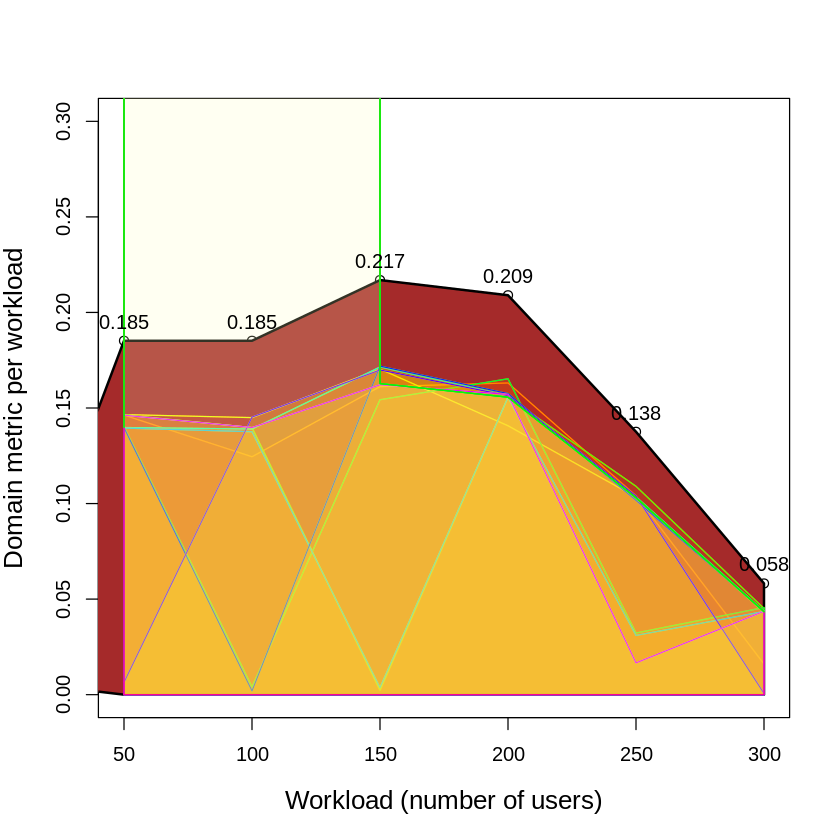

In [52]:
#Plot operational_profile against domain metric for each configuration

plot(aggregated_values_from_operational_profile, xlim=c(steps, max_no_of_users), ylim=c(0, 0.3),cex.lab=1.3)
polygon(c(steps,aggregated_values_from_operational_profile[,1],max_no_of_users),c(0,aggregated_values_from_operational_profile[,2],0), col="brown", lty = 1, lwd = 2, border = "black")
color=heat.colors(11)
color_transparent <- adjustcolor(color, alpha.f = 0.2) 

sorted_domain_metric<-domain_metric
k<-which(sorted_domain_metric[,2]==max(sorted_domain_metric[,2]))
#Green line whithin the polygon is the best domain matric line. 
#It corresponds to the second line in the final table below

for(i in 1:nrow(test_sets)) {
    lines(domain_metric_list[[i]], type="l", col=heat.colors(11)[i])    
    lines(domain_metric_list[[k]], type="l", col="green")
    polygon(c(steps,t(domain_metric_list[[i]][1]),max_no_of_users),c(0,t(domain_metric_list[[i]][2]),0), col=color_transparent[i], lty = 1, lwd = 1 , border = rainbow(11)[i])
}

text(aggregated_values_from_operational_profile,labels = round(aggregated_values_from_operational_profile[,2],3), pos=3, col="black")

graphics.off()

In [150]:
DBI::dbDisconnect(db_connection)

[1] TRUE